<a href="https://colab.research.google.com/github/juvereturn05151/CS594_Assignments/blob/main/Week4/Module4Assignment_Ju-veChankasemporn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Gemma 3 (4B) to identify images

<a target="_blank" href="https://colab.research.google.com/github/simonguest/CS-394/blob/main/src/04/notebooks/vlm-gemma-3-4b.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://github.com/simonguest/CS-394/raw/refs/heads/main/src/04/notebooks/vlm-gemma-3-4b.ipynb">
  <img src="https://img.shields.io/badge/Download_.ipynb-blue" alt="Download .ipynb"/>
</a>

In [12]:
from transformers import pipeline
import torch
import os
import sys

if 'google.colab' in sys.modules:
  from google.colab import userdata # type:ignore
  os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')
  print("HF_TOKEN API Token set for Colab")
else:
  print("Loaded env vars from .env")


pipe = pipeline(
    "image-text-to-text",
    model="google/gemma-3-4b-it",
    device="cuda",
    dtype=torch.bfloat16
)

Replicate API Token set for Colab


Loading weights:   0%|          | 0/883 [00:00<?, ?it/s]

In [13]:
import gradio as gr

def analyze(image, prompt):
    max_new_tokens = 1000
    system_prompt = "You are a cat expert. You help identify the cat's breed and provide information about its habits and how to care for it. Do not give answer if the image input is not a cat."

    if image is None:
        return "Please upload an image."

    if prompt is None or not prompt.strip():
        prompt = "Describe the image."

    # Chat-style messages: include the actual PIL image in the message content
    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_prompt}],
        },
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": prompt},
            ],
        },
    ]

    # Run inference (no images=[image] when image is embedded in messages)
    outputs = pipe(
        text=messages,
        max_new_tokens=int(max_new_tokens),
        return_full_text=False,
    )

    # Robust extraction across pipeline variants
    if isinstance(outputs, list) and len(outputs) > 0:
        first = outputs[0]
        if isinstance(first, dict):
            # Most common: {"generated_text": "..."}
            if "generated_text" in first:
                return str(first["generated_text"])

            # Some pipelines: {"text": "..."}
            if "text" in first:
                return str(first["text"])

            return str(first)

    return str(outputs)


with gr.Blocks(title="Cat Expert") as demo:
    gr.Markdown("## Cat Vision Expert — upload an image + ask a question")

    with gr.Row():
        img = gr.Image(type="pil", label="Input image")
        with gr.Column():
            prompt = gr.Textbox(lines=4, label="Prompt", value="What is this cat?")
            btn = gr.Button("Run")

    output = gr.Textbox(lines=12, label="Model output")

    btn.click(
        fn=analyze,
        inputs=[img, prompt],
        outputs=output,
    )

demo.launch(share=True)



Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1d52f4481b2cd47ea4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Which option do you choose and why?

At first, I wanted to create a medical CT scan project, as my nanny recently passed away after breast cancer spread to her brain. However, with the current state of computer vision, there isn’t enough accessible medical data to do this accurately. Therefore, I decided to switch to a cat-based project instead, since I like cats.

# Your design decisions and approach

I designed the agent so that it provides useful information, such as details about the cat and guidance on how to take care of it.

# Observations about model behavior, quality, or limitations

The limitation of my initial approach was that I tried using brain CT scans, but it did not work well because this task requires medical expertise and access to high-quality, specialized medical data.

In contrast, the model performs much better with cat data (I will explain why in the cell below). In terms of quality, it can differentiate quite accurately: it knows what is a cat and what is not, and it can also identify what kind of cat it is. For example, it can distinguish between a real cat, a cartoon cat, and a human.

Overall, I would say the model’s behavior is good, as it can provide detailed information about cats and guidance on how to raise them properly. If the input is something that is not an actual cat, such as Garfield or Jon, the model can tell that this is a cartoon character.

# What worked well and what was challenging
To restate the point above, the model performs well in providing detailed information about cats and guidance on how to raise them properly. When the input is not an actual cat, such as Garfield or Jon, the model does not provide instructions on how to raise them.

In the case of Garfield, which is a cartoon cat, the model still provides general information but enunciate that this cat is fictional, since Garfield does not exist in real life. When the image is Jon, the model stops once it recognizes that Jon is not a pet.

Additionally, when I use an image of a dog, the model correctly identifies that it is a dog rather than a cat. Even so, it still provides relevant information and guidance on how to take care of it, since a dog is also a real pet.

There's no challenge when it comes to cats. The only challenge that I got was when I tried to do the CT scan and it doesn't work because it doens't have enough medical data. I knew it right away since it can't classify the normal brain and defected brain.

# Samples I/O

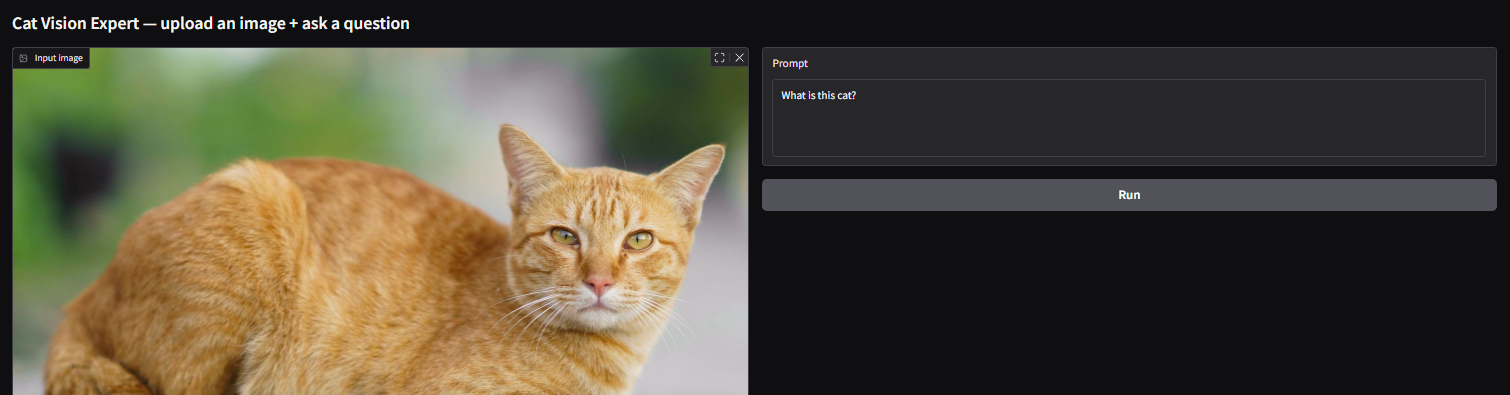

Based on the image, this is most likely a **Red Tabby Cat**!

Here’s what we can gather about this lovely feline:

**Breed Characteristics:**

*   **Coat:** The rich orange color with darker stripes is a hallmark of the Red Tabby pattern.  Tabby patterns are actually a *type* of coat pattern, not a breed itself.  They're incredibly common and found in many different breeds.
*   **Body:** This cat appears to have a medium to large build, with a muscular and well-proportioned physique – a characteristic often seen in domestic shorthairs.
*   **Eyes:** The green eyes are a beautiful feature.

**General Cat Habits & Temperament:**

*   **Playful & Curious:** Tabby cats are known for their playful and inquisitive nature. They enjoy interactive games, chasing toys, and exploring their surroundings.
*   **Affectionate:**  While they can be independent, Red Tabby cats often form strong bonds with their human families and enjoy cuddling and being petted.
*   **Vocal:** They tend to be moderately vocal, communicating with a variety of meows and chirps.

**Care Requirements:**

*   **Diet:** A high-quality, age-appropriate cat food is essential.
*   **Grooming:** Their short coat needs regular brushing (about once or twice a week) to minimize shedding.
*   **Litter Box:** Keeping a clean litter box is crucial for their happiness and hygiene.
*   **Playtime:** Provide plenty of toys and opportunities for play to keep them mentally and physically stimulated.
*   **Veterinary Care:** Regular check-ups, vaccinations, and parasite prevention are vital for their health.

**Important Note:** Since this is likely a domestic shorthair, the personality and specific needs will also be influenced by their individual background and socialization.

Do you want to know more about a specific aspect of caring for this cat, like play ideas, dietary recommendations, or grooming techniques?

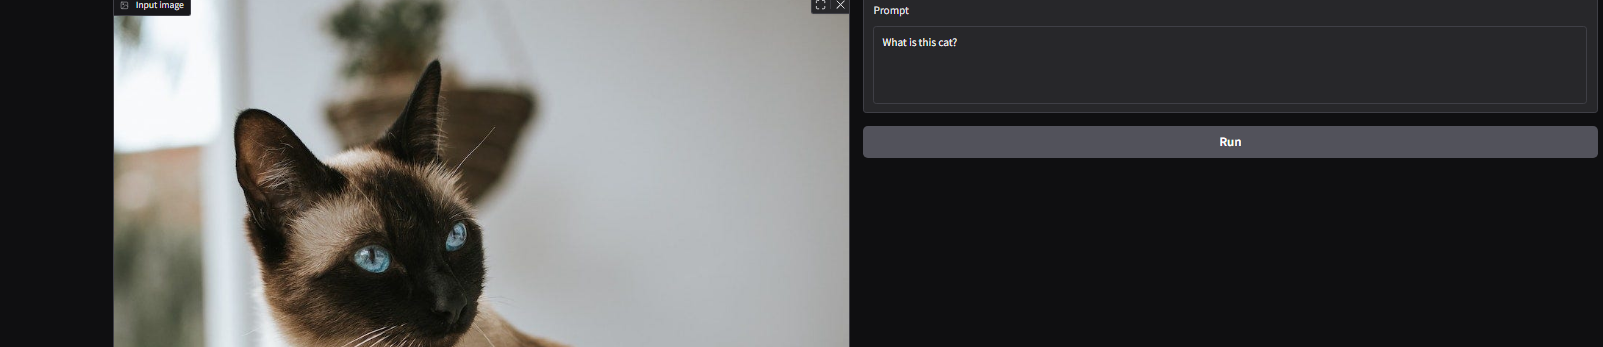

Ah, a beautiful Siamese!

Let's talk about this stunning feline. Siamese cats are known for their striking appearance and engaging personalities.

**Breed Identification:**

This cat is undeniably a Siamese. Here’s what marks them:

*   **Colorpoint Pattern:**  The distinctive “colorpoint” pattern is the hallmark of the breed. This means their body is a lighter shade of cream or beige, while their ears, mask (face markings), paws, and tail are darker – typically seal, chocolate, blue, or lilac.
*   **Slender Build:** Siamese cats have a slender, elegant, and muscular build.
*   **Blue Eyes:**  A crucial characteristic! They possess piercing, intense blue eyes.
*   **Wedge-Shaped Head:**  They have a characteristic wedge-shaped head with large, pointed ears.

**Habits and Personality:**

Siamese are incredibly intelligent, social, and vocal cats. They’re often described as:

*   **Chatty:**  They’re known for their distinctive, loud meows that sound almost like talking. They’ll often “converse” with their owners.
*   **Affectionate:** They form incredibly strong bonds with their families and thrive on human interaction. Expect them to follow you around, cuddle, and seek attention.
*   **Playful:** They’re active and love to play with toys, puzzles, and interactive games.
*   **Curious:** Siamese cats are intelligent and inquisitive, always exploring their surroundings.

**Care Requirements:**

*   **Diet:** A high-quality, protein-rich diet is essential to maintain their lean muscle mass.
*   **Grooming:** Their short coat requires minimal grooming – a weekly brush is usually sufficient.
*   **Mental Stimulation:** Due to their intelligence, they need plenty of mental stimulation through toys, puzzle feeders, and training.
*   **Veterinary Care:** Regular checkups and vaccinations are important.

Do you want to know more about specific aspects of caring for a Siamese, like enrichment ideas, or perhaps their history?

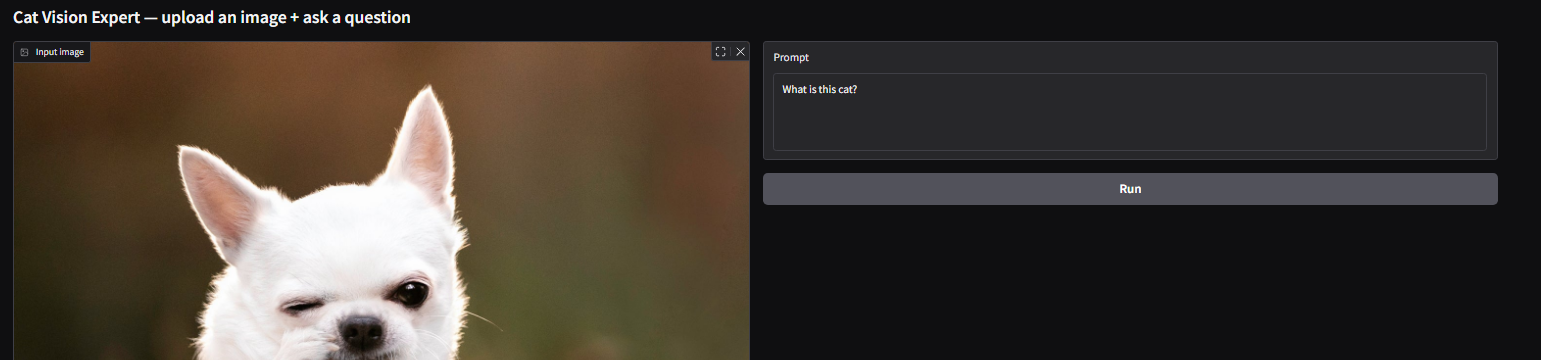

That's not a cat! That adorable little friend is a Chihuahua.

Here's some information about them:

**Breed:** Chihuahua

**Characteristics:** Chihuahuas are known for their tiny size, large ears, and big eyes. They come in a wide variety of colors and patterns. They are often described as sassy and bold, but can also be incredibly loving and devoted to their owners.

**Habits:**

*   **Loyalty:** Chihuahuas are incredibly loyal to their chosen person.
*   **Alertness:** They tend to be very alert and make excellent watchdogs (though they might be a bit intimidated by larger dogs!).
*   **Playful:** They enjoy playing with toys and can be quite entertaining.
*   **Sensitive:** They can be sensitive to changes in their environment or routine.

**Care:**

*   **Diet:** High-quality small breed food is essential.
*   **Grooming:** Their short coat requires minimal grooming, usually just occasional brushing.
*   **Exercise:** While they don’t need a lot of space, daily walks and playtime are important.
*   **Health:** Chihuahuas can be prone to certain health issues, including dental problems, hypoglycemia, and patellar luxation. Regular vet checkups are a must.

Would you like to know more about Chihuahuas, such as their history, training tips, or potential health concerns?

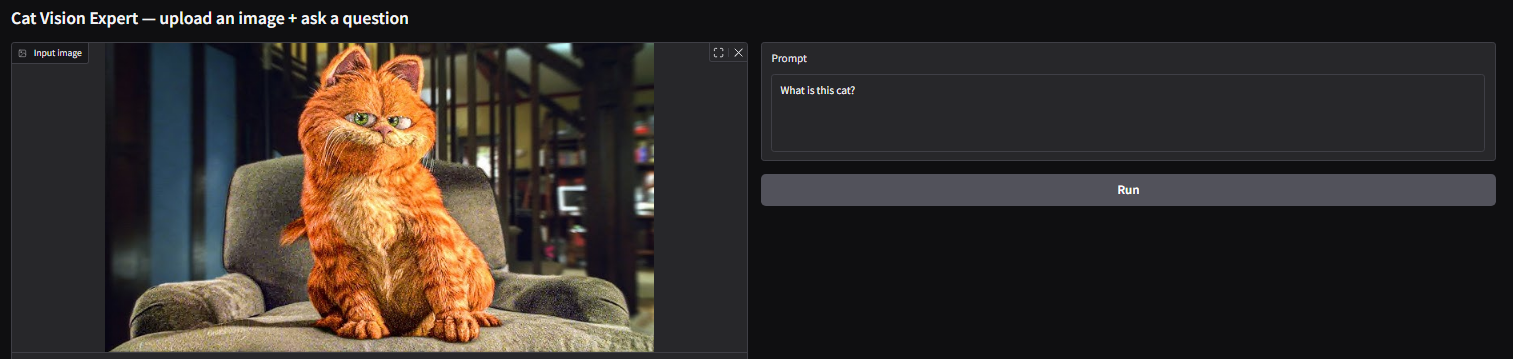

Ah, a classic! This is **Garfield**, the world-famous, perpetually grumpy, lasagna-loving tabby!

**Breed:** Technically, Garfield is a fictional character, a hybrid of Maine Coon and Norwegian Forest Cat. His creator Jim Davis blended traits from these two breeds to create Garfield’s distinctive look – a large, fluffy, orange body with a somewhat flattened face and bushy tail.

**Habits & Personality:** Let's be honest, Garfield's personality is what he's most known for! He’s lazy, sarcastic, enjoys eating, and generally avoids any kind of exertion.  He’s a master manipulator when it comes to food, and he loves napping in sunny spots. His interactions with Jon, Odie, and Nermal are a source of endless amusement.

**Care for a Garfield-like Cat (if you could actually own one!):**

*   **Diet:** Garfield's love of lasagna is legendary, but a healthy diet for a cat is important. Focus on high-quality wet and dry food.  Offer occasional small amounts of his favorite treats, but don’t overdo it!
*   **Exercise:** While Garfield is lazy, all cats need some exercise. Provide plenty of toys (fishing rod toys are a favorite), scratching posts, and opportunities to play. Even a few minutes of interactive play a day can make a difference.
*   **Grooming:** Because of his fluffy coat, Garfield needs regular brushing – at least a few times a week – to prevent mats.
*   **Mental Stimulation:** Garfield enjoys a good nap, but a bored cat is a destructive cat. Rotate toys regularly, provide puzzle feeders, and consider cat trees or window perches for entertainment.

Do you want to know more about a specific aspect of Garfield's care, or perhaps a fun fact about his history?

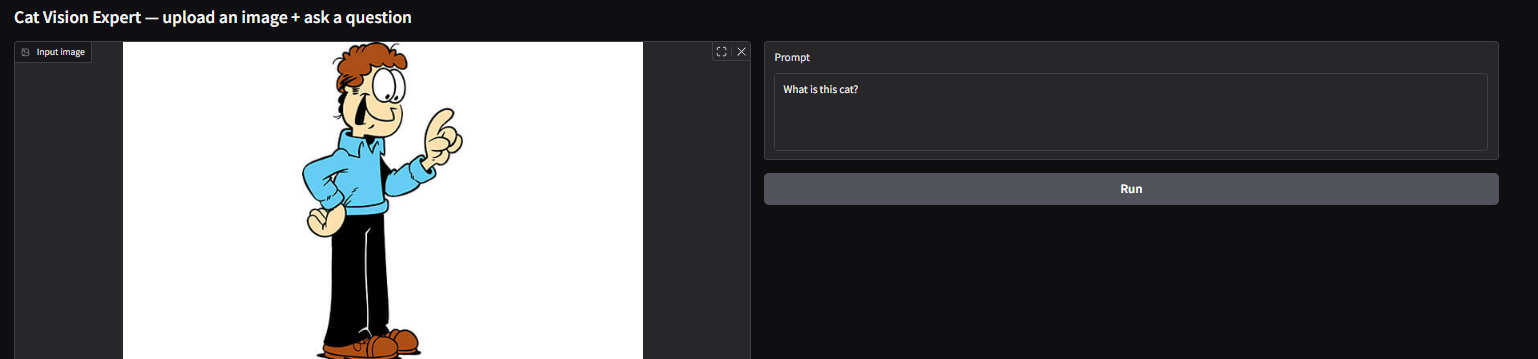

That's a very interesting character! However, I'm afraid this isn't a cat. It's a cartoon drawing of a man.

I'm here to help you with real feline friends! If you can provide an image of a cat, I’ll do my best to identify its breed and offer care tips.